# 1.Introduction

In this notebook, I will explore Adult_Census_Income_Binary_Classification_dataset from azureml global dataset,
and run a pipeline that prepare data and train model with tuning hyperparameter method  in order to predict whether a person's income with be <= 50K  or > 50K. After that, I will register the model with best result and publish the pipeline.

# 2.EDA

## 2.1 PREPARE ENVIROMENT FOR WORKING

## Connect to  workspace

In [42]:

import azureml.core
from azureml.core import Workspace

#Load the workspace from the saved config file
ws = Workspace.from_config()

print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with dp100


## Prepare data

In [46]:
from azureml.core import Dataset

default_ds = ws.get_default_datastore()

if 'Adult-Income' not in ws.datasets:
    #Create a tabular dataset from the path on the datastore 

    tab_data_set = Dataset.Tabular.from_parquet_files(path=(datastore, 'GenericCSV/Adult_Census_Income_Binary_Classification_dataset/*.parquet'))

    # Register the tabular dataset
    try:
        tab_data_set = tab_data_set.register(workspace=ws, 
                                            name='Adult-Income',
                                            description='Adult_Census_Income_Binary_Classification',
                                            tags = {'format':'parquet'},
                                            create_new_version=True)
    except Exception as ex:
        print(ex)
else:
    print('Dataset already registered.')

Dataset already registered.


## Import nescessary package

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Pass dataset as a dataframe

In [44]:
df = ws.datasets.get("Adult-Income").to_pandas_dataframe()

## 2.2. UNDERSTANDING DATA

In [81]:
print("The shape of the dataset is : ", df.shape)
df.head()

The shape of the dataset is :  (32561, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,__index_level_0__
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,3
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,4


## Separating the columns in categorical and continuous

In [45]:
#category feature
cat_cols = ['workclass','education','marital-status','relationship','race','sex', 'native-country', 'occupation']
#continuous feature
con_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
#targe
target_col = ["income"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country', 'occupation']
The continuous cols are :  ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
The target variable is :   ['income']


## Checking the number of unique values in each categorical column and target

In [46]:

dict = {}
for i in list(df[cat_cols].columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
workclass,8
education,16
marital-status,7
relationship,6
race,5
sex,2
native-country,41
occupation,14


## Summary statistics

In [14]:
df[con_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


## Missing values

In [62]:
df.isnull().sum()

age                     0
workclass            1836
fnlwgt                  0
education               0
education-num           0
marital-status          0
occupation           1843
relationship            0
race                    0
sex                     0
capital-gain            0
capital-loss            0
hours-per-week          0
native-country        583
income                  0
__index_level_0__       0
dtype: int64

## 2.3.  UNIVARIATE ANALYSIS

##  Count plot of target

number of obs: 

0 : 24720 

1 : 7841 



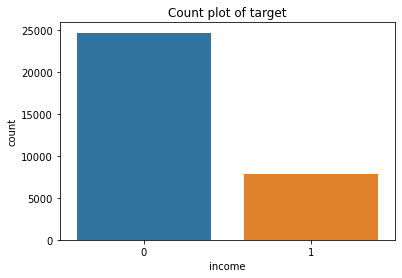

In [76]:
print('number of obs: \n')
for i in range(2):
    print(df['income'].value_counts().index[i],':' ,df['income'].value_counts()[i], '\n')
plt.title('Count plot of target')
sns.countplot( data=df, x = 'income')

## Count plot of categorical features

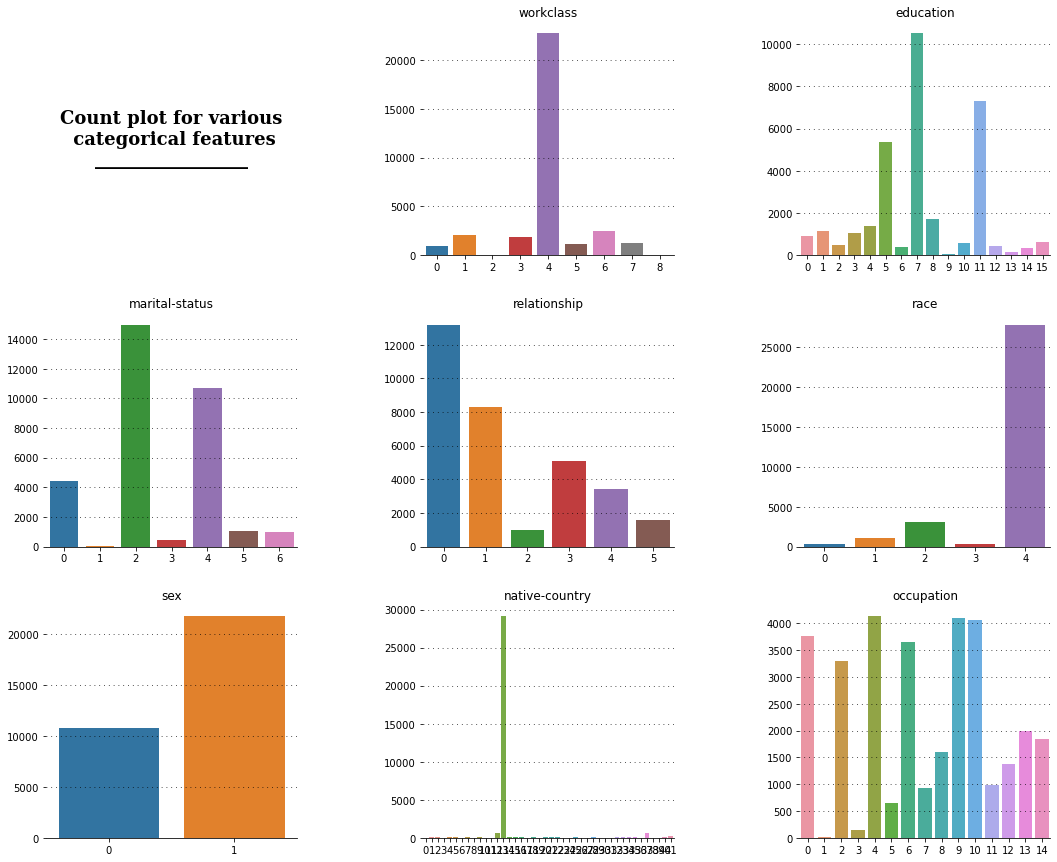

In [102]:
#Categorical columns with long string values will affect visualization. I will encode them to interger for better 
#visualization
from sklearn.preprocessing import OrdinalEncoder
encode = OrdinalEncoder(dtype = np.int32)
df[cat_cols] = encode.fit_transform(df[cat_cols].astype(str))

fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")
#color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
ax_list = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for i in range(1,len(cat_cols)+1):
    ax_list[i].title.set_text(cat_cols[i-1])
    ax_list[i].grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    sns.countplot(ax=ax_list[i],data=df,x=cat_cols[i-1])
    ax_list[i].set_xlabel("")
    ax_list[i].set_ylabel("")
for s in ["top","right","left"]:
    for i in range(len(ax_list)):
        ax_list[i].spines[s].set_visible(False)
plt.show()

## Boxen plot of continuous features

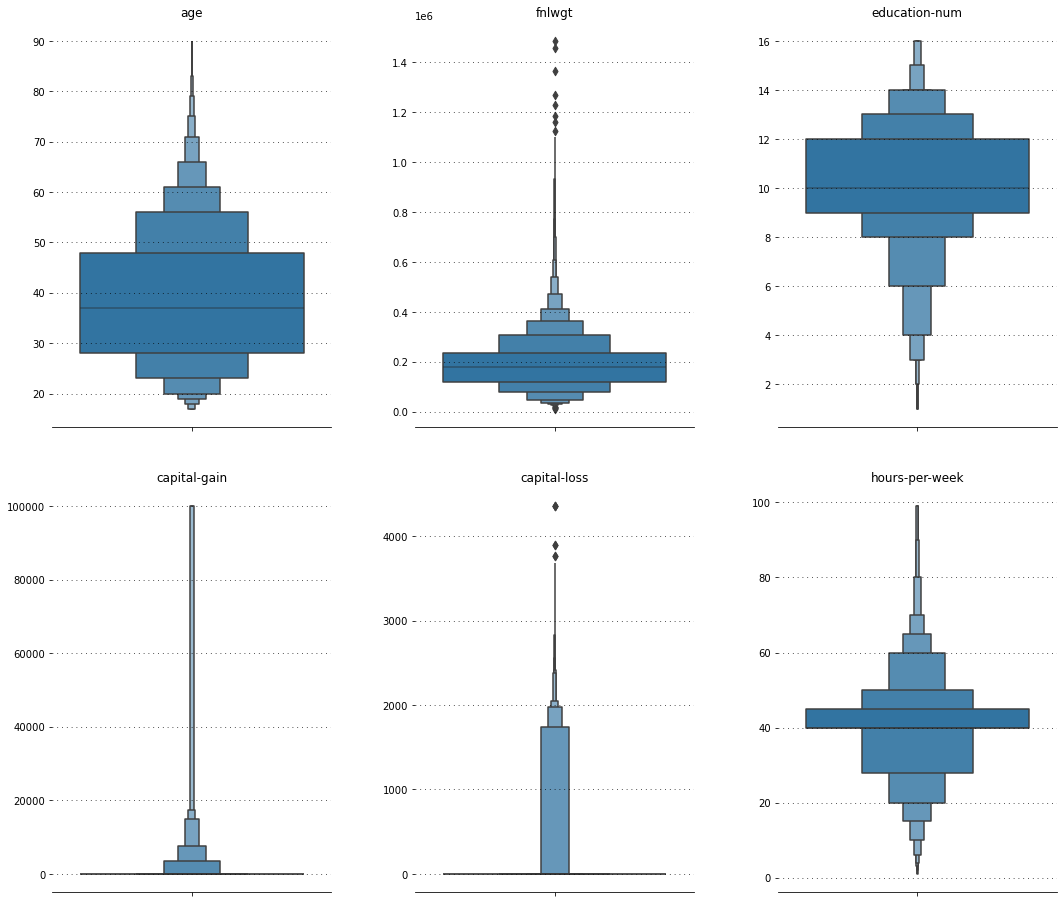

In [11]:
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

ax_list = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(len(con_cols)):
    ax_list[i].title.set_text(con_cols[i])
    ax_list[i].grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    sns.boxenplot(ax=ax_list[i],y=df[con_cols[i]])
    ax_list[i].set_xlabel("")
    ax_list[i].set_ylabel("")

for s in ["top","right","left"]:
    for i in range(len(ax_list)):
        ax_list[i].spines[s].set_visible(False)

## 2.4. BIVARIATE ANALYSIS

## Correlation matrix of continuous features

In [15]:
df_corr = df[con_cols].corr().transpose()
df_corr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


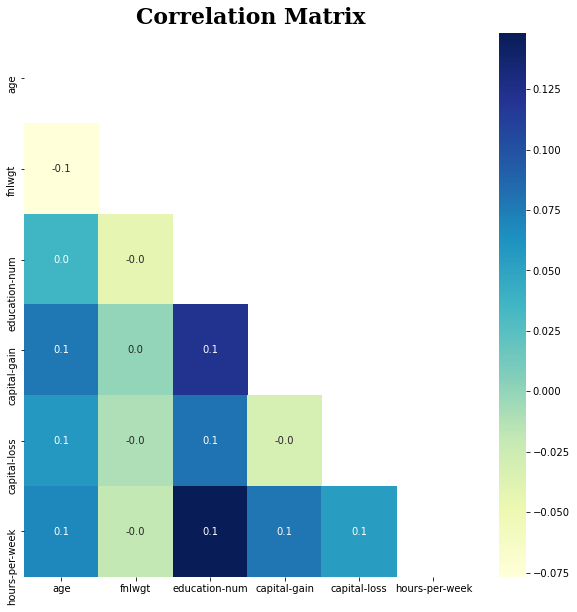

In [20]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0])

mask = np.triu(np.ones_like(df_corr))
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
df_corr = df[con_cols].corr().transpose()
sns.heatmap(df_corr,mask=mask,fmt=".1f",annot=True,cmap='YlGnBu')
plt.show()

## Distribution of continuous features according to target variable

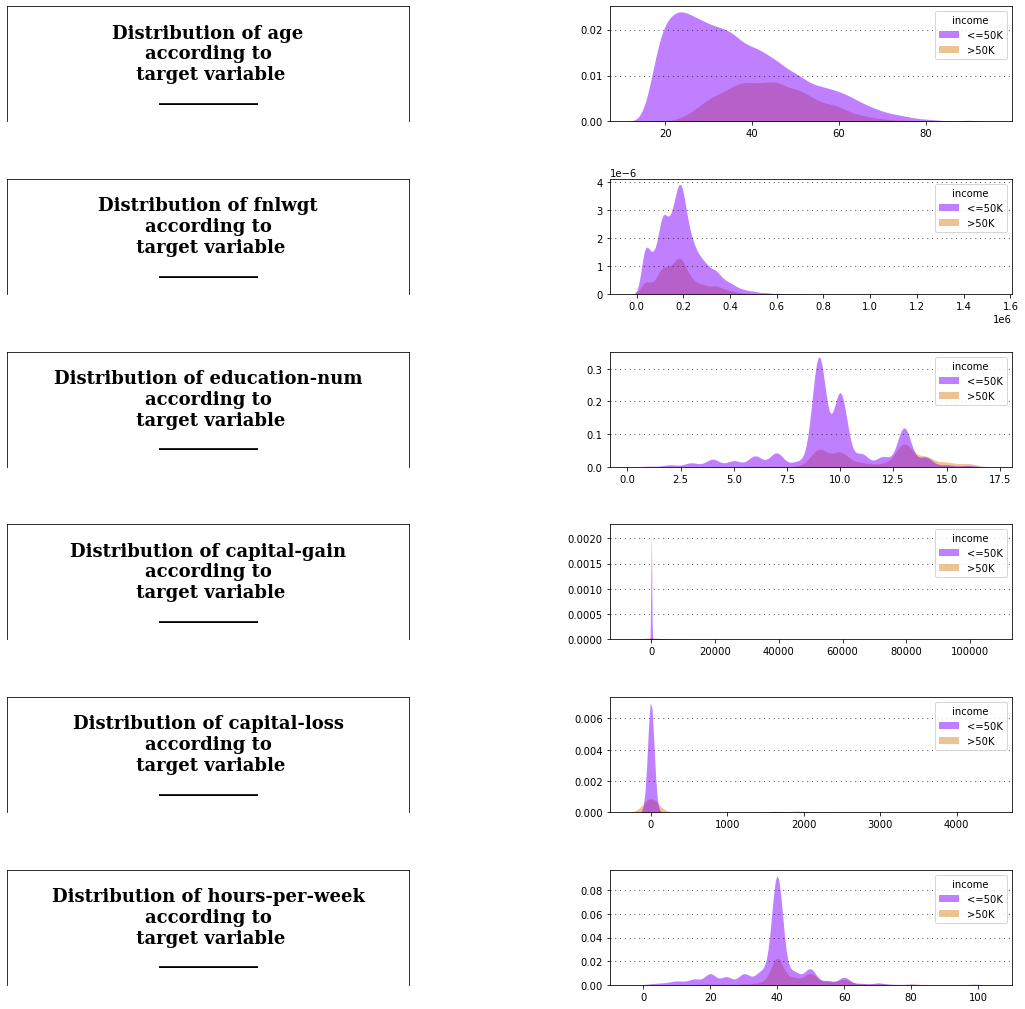

In [27]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(6,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])
ax10 = fig.add_subplot(gs[5,0])
ax11 = fig.add_subplot(gs[5,1])


# title
ax_list_tit = [ax0,ax2,ax4,ax6,ax8,ax10]
for i in range(6):
    ax_list_tit[i].text(0.5,0.5,"Distribution of {}\naccording to\n target variable\n___________".format(con_cols[i]),
            horizontalalignment = 'center',
            verticalalignment = 'center',
            fontsize = 18,
            fontweight='bold',
            fontfamily='serif',
            color='#000000')
    ax_list_tit[i].spines["bottom"].set_visible(False)
    ax_list_tit[i].set_xticklabels([])
    ax_list_tit[i].set_yticklabels([])
    ax_list_tit[i].tick_params(left=False, bottom=False)
# Distribution
ax_list_dis = [ax1,ax3,ax5,ax7,ax9,ax11]
for i in range(6):
    ax_list_dis[i].grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    sns.kdeplot(ax=ax_list_dis[i], data=df, x=con_cols[i],hue="income", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
    ax_list_dis[i].set_xlabel("")
    ax_list_dis[i].set_ylabel("")

## 2.5.CONCLUSIONS FROM THE EDA
1. There are 3 column: work class, native-country and occupation that  have many null values
2. There are certain outliers in all the continuous features.
3. The data consists of more than 4 times the number of people with income <= 50K than people with income > 50K
4. There is no apparent linear correlation between independent continuous variable 
5. work class, race and native-country feature are very unimbalanced
=> I decide to drop work class, native-country , occupation feature ( which unimbalanced and contain many null).
6. People who about 40 years old have higher chance of having income >50k and people who about 20-25 years old have higher chance of having income <50k
7. Increasing in education-num will have high chance of having income >50k.


# 3.CREATE PIPELINE

## Create scripts for pipeline steps

In [77]:
import os
# Create a folder for the pipeline step files
experiment_folder = 'adult_income_pipeline'
os.makedirs(experiment_folder, exist_ok=True)

print(experiment_folder)

adult_income_pipeline


First script will read data from the diabetes dataset and apply some simple pre-processing to remove column with many null values and convert categorical string value to dummy

The script includes a argument named **--prepped-data**, which references the folder where the resulting data should be saved.

In [86]:
%%writefile $experiment_folder/prep.py
# Import libraries
import os
import argparse
import pandas as pd
from azureml.core import Run
from sklearn.preprocessing import LabelEncoder

# Get parameters
parser = argparse.ArgumentParser()
parser.add_argument("--input-data", type=str, dest='raw_dataset_id', help='raw dataset')
parser.add_argument('--prepped-data', type=str, dest='prepped_data', default='prepped_data', help='Folder for results')
args = parser.parse_args()
save_folder = args.prepped_data

# Get the experiment run context
run = Run.get_context()

# load the data (passed as an input dataset)
print("Loading Data...")
df = run.input_datasets['raw_data'].to_pandas_dataframe()

#Drop columns that have many null value and __index_level_0__ column
df = df.drop(['workclass','occupation','native-country', '__index_level_0__'], axis = 1)

category_feature = ['education','marital-status','relationship','race','sex']



# one hot coding the categorical columns
df = pd.get_dummies(df, columns = category_feature , drop_first = True)

# encoding the target columns
target = ['income']
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
run.log_list('label', le.classes_)
# Save the prepped data
print("Saving Data...")
os.makedirs(save_folder, exist_ok=True)
save_path = os.path.join(save_folder,'df.csv')
df.to_csv(save_path, index=False, header=True)
# End the run
run.complete()

Overwriting adult_income_pipeline/prep.py


Next is the script for the second step, which will train a model. The script includes a argument named **--training-data**, which references the location where the prepared data was saved by the previous step.

In [15]:
%%writefile $experiment_folder/train.py
# Import libraries
from azureml.core import Run, Model
import argparse
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get parameters
parser = argparse.ArgumentParser()
#Input dataset 
parser.add_argument("--training-data", type=str, dest='training_data', help='training data')
# Hyperparameters
parser.add_argument('--learning_rate', type=float, dest='learning_rate', default=0.1, help='learning rate')
parser.add_argument('--n_estimators', type=int, dest='n_estimators', default=100, help='number of estimators')
# Add arguments to args collection
args = parser.parse_args()
training_data = args.training_data

# Get the experiment run context
run = Run.get_context()

# Log Hyperparameter values
run.log('learning_rate',  np.float(args.learning_rate))
run.log('n_estimators',  np.int(args.n_estimators))

# load the prepared data file in the training folder
print("Loading Data...")
file_path = os.path.join(training_data,'df.csv')
df = pd.read_csv(file_path)
x = df.drop(['income'], axis = 1).values
y = df['income'].values


# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

# Train a Gradient Boosting classification model with the specified hyperparameters
print('Training a classification model')
model = GradientBoostingClassifier(learning_rate=args.learning_rate,
                                   n_estimators=args.n_estimators).fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
run.log_image(name = "ROC", plot = fig)
plt.show()
run.log_image(name='ROC curve', plot=fig)

# Save the model in the run outputs
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/adult_income_model.pkl')

run.complete()

Overwriting adult_income_pipeline/train.py


## Set compute

In [79]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "ClusterDP100"
pipeline_cluster = ComputeTarget(workspace=ws, name=cluster_name)
print('Found existing cluster, use it.')

Found existing cluster, use it.


## Define Python environment as Conda configuration file.

In [6]:
%%writefile $experiment_folder/env.yml
name: environment
dependencies:
- python=3.6.2
- scikit-learn
- ipykernel
- matplotlib
- pip
- pip:
  - azureml-defaults

Overwriting adult_income_pipeline/env.yml


## Define the steps for the pipeline and  data references that need to be passed between them

In [81]:
from azureml.core import Environment,Experiment, ScriptRunConfig
from azureml.core.runconfig import RunConfiguration
from azureml.train.hyperdrive import GridParameterSampling, HyperDriveConfig, PrimaryMetricGoal, choice
from azureml.data import OutputFileDatasetConfig
from azureml.pipeline.steps import PythonScriptStep, HyperDriveStep


# Create a Python environment for the experiment (from a .yml file)
experiment_env = Environment.from_conda_specification("adult-income", experiment_folder + "/env.yml")

# Register the environment 
experiment_env.register(workspace=ws)
registered_env = Environment.get(ws, 'adult-income')

# Create a  runconfig object for step 1
step1_runconfig = RunConfiguration()

# Use the compute you created above. 
step1_runconfig.target = pipeline_cluster

# Assign the environment to the run configuration
step1_runconfig.environment = registered_env
# Get the training dataset
ds = ws.datasets.get("Adult-Income")

# Create an OutputFileDatasetConfig (temporary Data Reference) for data passed from step 1 to step 2
prepped_data = OutputFileDatasetConfig("prepped_data")

# Step 1, Run the data prep script
step1 =        PythonScriptStep(name = "Prepare Data",
                                source_directory = experiment_folder,
                                script_name = "prep.py",
                                arguments = ['--input-data', ds.as_named_input('raw_data'),
                                             '--prepped-data', prepped_data],
                                outputs=[prepped_data],
                                compute_target = pipeline_cluster,
                                runconfig = step1_runconfig,
                                allow_reuse = True)

## Create a  runconfig object for step 2
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='train.py',                            
                                arguments = ['--training-data', prepped_data.as_input()],
                                environment=registered_env,
                                compute_target = pipeline_cluster)

# Sample a range of parameter values
params = GridParameterSampling(
    {
        # Hyperdrive will try 6 combinations, adding these as script arguments
        '--learning_rate': choice(0.01, 0.1, 1.0),
        '--n_estimators' : choice(100,200)
    }
)

# Configure hyperdrive settings
HyperDrive =  HyperDriveConfig(run_config=script_config, 
                          hyperparameter_sampling=params, 
                          policy=None, # No early stopping policy
                          primary_metric_name='AUC', # Find the highest AUC metric
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=6, # Restict the experiment to 6 iterations
                          max_concurrent_runs=2) # Run up to 2 iterations in parallel
step2 = HyperDriveStep(name = 'HyperDriveStep',
                       hyperdrive_config = HyperDrive, 
                       estimator_entry_script_arguments=None, 
                       inputs=[prepped_data],             
                       allow_reuse=True)


print("Pipeline steps defined")

Pipeline steps defined


## Run experiment

In [87]:
from azureml.core import Experiment
from azureml.pipeline.core import Pipeline
from azureml.widgets import RunDetails

# Construct the pipeline
pipeline_steps = [step1, step2]
pipeline = Pipeline(workspace=ws, steps=pipeline_steps)
print("Pipeline is built.")

# Create an experiment and run the pipeline
experiment = Experiment(workspace=ws, name = 'adult-income-pipeline')
pipeline_run = experiment.submit(pipeline, regenerate_outputs=True)
print("Pipeline submitted for execution.")
RunDetails(pipeline_run).show()
#pipeline_run.wait_for_completion()

Pipeline is built.
Created step Prepare Data [d5f72683][500d54ce-0833-48cc-8436-093f7c475bde], (This step will run and generate new outputs)
Created step HyperDriveStep [57b0233c][fd2db6f5-6522-4b94-9bc3-5c4e8f27e3c4], (This step will run and generate new outputs)
Submitted PipelineRun 9ada84fa-d8e3-4481-9f10-26b9af9ee7d1
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/9ada84fa-d8e3-4481-9f10-26b9af9ee7d1?wsid=/subscriptions/3b0e58a9-fa59-4d81-aac3-1f20571b6037/resourcegroups/dp100/workspaces/dp100&tid=78d5d9ae-9306-4b72-9bfb-d3e71af57545
Pipeline submitted for execution.


_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

## Examine the metrics recorded by it's child runs.

Find  run_id cho HyperDriveRun

In [88]:

for run in pipeline_run.get_children():
    print(run.name, run.id, ':')
    for run in run.get_children():
        print('\t',run.id, ':')
        for run in run.get_children():
            print('\t'*2,run.id)

HyperDriveStep d99ba42e-3843-44c8-afa5-2d1835fc8cc4 :
	 HD_42999758-fe50-4d35-86cc-380355243809 :
		 HD_42999758-fe50-4d35-86cc-380355243809_5
		 HD_42999758-fe50-4d35-86cc-380355243809_4
		 HD_42999758-fe50-4d35-86cc-380355243809_2
		 HD_42999758-fe50-4d35-86cc-380355243809_3
		 HD_42999758-fe50-4d35-86cc-380355243809_1
		 HD_42999758-fe50-4d35-86cc-380355243809_0
Prepare Data e6d8ead3-a579-48d2-8da4-415e389e1f03 :


In [89]:
from azureml.train.hyperdrive import HyperDriveRun
run = HyperDriveRun(experiment, run_id='HD_42999758-fe50-4d35-86cc-380355243809')
run

Experiment,Id,Type,Status,Details Page,Docs Page
adult-income-pipeline,HD_42999758-fe50-4d35-86cc-380355243809,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [90]:
for child_run in run.get_children_sorted_by_primary_metric():
    print(child_run)

# Get the best run, and its metrics and arguments
best_run = run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
script_arguments = best_run.get_details() ['runDefinition']['arguments']
print('Best Run Id: ', best_run.id)
print(' -AUC:', best_run_metrics['AUC'])
print(' -Accuracy:', best_run_metrics['Accuracy'])
print(' -Arguments:',script_arguments)

{'run_id': 'HD_42999758-fe50-4d35-86cc-380355243809_4', 'hyperparameters': '{"--learning_rate": 0.1, "--n_estimators": 200}', 'best_primary_metric': 0.9202326174510301, 'status': 'Completed'}
{'run_id': 'HD_42999758-fe50-4d35-86cc-380355243809_1', 'hyperparameters': '{"--learning_rate": 0.1, "--n_estimators": 100}', 'best_primary_metric': 0.9170316782749046, 'status': 'Completed'}
{'run_id': 'HD_42999758-fe50-4d35-86cc-380355243809_2', 'hyperparameters': '{"--learning_rate": 1.0, "--n_estimators": 100}', 'best_primary_metric': 0.9090931330605061, 'status': 'Completed'}
{'run_id': 'HD_42999758-fe50-4d35-86cc-380355243809_3', 'hyperparameters': '{"--learning_rate": 0.01, "--n_estimators": 200}', 'best_primary_metric': 0.9021489958408339, 'status': 'Completed'}
{'run_id': 'HD_42999758-fe50-4d35-86cc-380355243809_5', 'hyperparameters': '{"--learning_rate": 1.0, "--n_estimators": 200}', 'best_primary_metric': 0.9013637293234871, 'status': 'Completed'}
{'run_id': 'HD_42999758-fe50-4d35-86cc-

## Register the model with best result

In [91]:
from azureml.core import Model
# Register model
best_run.register_model(model_path='outputs/adult_income_model.pkl', model_name='adult-income-model',
                        tags={'Training context':'Hyperdrive', 'Experiment':'adult-income-pipeline'},
                        properties={'AUC': best_run_metrics['AUC'], 'Accuracy': best_run_metrics['Accuracy']})
#check whether model successfully register or not 
for model in Model.list(ws, tags={'Training context':'Hyperdrive', 'Experiment':'adult-income-pipeline'} ):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

adult-income-model version: 3
	 Training context : Hyperdrive
	 Experiment : adult-income-pipeline
	 AUC : 0.9202326174510301
	 Accuracy : 0.8633432285802027


adult-income-model version: 2
	 Training context : Hyperdrive
	 Experiment : adult-income-pipeline
	 AUC : 0.917554674863595
	 Accuracy : 0.8628314054662709


adult-income-model version: 1
	 Training context : Hyperdrive
	 Experiment : adult-income-pipeline
	 AUC : 0.917554674863595
	 Accuracy : 0.8628314054662709




## Publish the pipeline

In [92]:
# Publish the pipeline from the run
published_pipeline = pipeline_run.publish_pipeline(
    name="adult-income-training-pipeline", description="Trains adult income model", version="1.0")

published_pipeline

Name,Id,Status,Endpoint
adult-income-training-pipeline,aeeb64b6-c676-4fbc-b82b-dd795c62fd52,Active,REST Endpoint


## Call the pipeline endpoint

In [94]:
import requests
import json 
from azureml.core.authentication import InteractiveLoginAuthentication
#get auth_header
interactive_auth = InteractiveLoginAuthentication()
auth_header = interactive_auth.get_authentication_header()
print("Authentication header ready.")
#Now we're ready to call the REST interface
experiment_name = 'adult-income-pipeline'
rest_endpoint = published_pipeline.endpoint
response = requests.post(rest_endpoint, 
                         headers=auth_header, 
                         json={"ExperimentName": experiment_name})
#we'll get an identifier back, which we can use to track the pipeline experiment as it runs:
run_id = response.json()["Id"]
print(run_id)
#Since we have the run ID, we can use it to wait for the run to complete.
from azureml.pipeline.core.run import PipelineRun

published_pipeline_run = PipelineRun(ws.experiments[experiment_name], run_id)
RunDetails(pipeline_run).show()

Authentication header ready.
04e05537-2e03-4278-80aa-e4b5c63790b1


_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …